In [1]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.67+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [ ]:
# check available devices
import jax

In [2]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

jax backend cpu


[CpuDevice(id=0)]

# 🦎 Online linear regression with a non-stationary environment 🦎

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/06_Online_Linear_Regression.ipynb)

We implement an online learning non-stationary linear regression problem.

We go there progressively by showing how a linear regression problem can be cast
into an online learning problem thanks to the `OnlineSupervisedLearner` module.

Then, to tackle a non-stationary linear regression problem (i.e. with a weight that can vary in time)
we reformulate the problem into a reinforcement learning problem that we implement with the `GymFeedBack` module of WAX-ML.

We then need to define an "agent" and an "environment" using simple functions implemented with modules:
- The agent is responsible for learning the weights of its internal linear model.
- The environment is responsible for generating labels and evaluating the agent's reward metric.

We experiment with a non-stationary environment that returns the sign of the linear regression parameters at a given time step,
known only to the environment.

This example shows that it is quite simple to implement this online-learning task with WAX-ML tools.
In particular, the functional workflow adopted here allows reusing the functions implemented for a
task for each new task of increasing complexity,


In this journey, we will use:
- Haiku basic linear module `hk.Linear`.
- Optax stochastic gradient descent optimizer: `sgd`.
- WAX-ML modules: `OnlineSupervisedLearner`, `Lag`, `GymFeedBack`
- WAX-ML helper functions: `unroll`, `jit_init_apply`

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import haiku as hk
import jax
import jax.numpy as jnp
import optax
from matplotlib import pyplot as plt

In [5]:
from wax.compile import jit_init_apply
from wax.modules import OnlineSupervisedLearner

## Static Linear Regression

First, let's implement a simple linear regression

### Generate data

Let's generate a batch of data:

In [6]:
seq = hk.PRNGSequence(42)
X = jax.random.normal(next(seq), (100, 3))
w_true = jnp.ones(3)

### Define the model

We use the basic module `hk.Linear` which is a linear layer.
By default, it initializes the weights with random values from the truncated normal,
with a standard deviation of $1 / \sqrt{N}$ (See https://arxiv.org/abs/1502.03167v3)
where $N$ is the size of the inputs.

In [7]:
@jit_init_apply
@hk.transform_with_state
def linear_model(x):
    return hk.Linear(output_size=1, with_bias=False)(x)

### Run the model

Let's run the model using WAX-ML `unroll` on the batch of data.

In [8]:
from wax.unroll import unroll

In [9]:
params, state = linear_model.init(next(seq), X[0])
linear_model.apply(params, state, None, X[0])

(DeviceArray([-0.2070887], dtype=float32), FlatMapping({}))

In [10]:
Y_pred = unroll(linear_model, rng=next(seq))(X)

In [11]:
Y_pred.shape

(100, 1)

### Check cost

Let's look at the mean squared error for this non-trained model.

In [12]:
noise = jax.random.normal(next(seq), (100,))
Y = X.dot(w_true) + noise
L = ((Y - Y_pred) ** 2).sum(axis=1)
mean_loss = L.mean()
assert mean_loss > 0

Let's look at the regret (cumulative sum of the loss) for the non-trained model.

Text(0.5, 1.0, 'Regret')

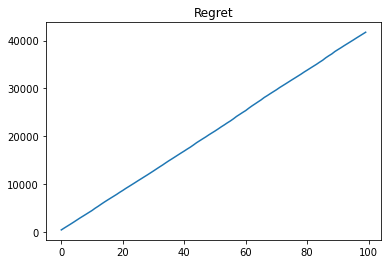

In [13]:
plt.plot(L.cumsum())
plt.title("Regret")

As expected, we have a linear regret when we did not train the model!

## Online Linear Regression

We will now start training the model online.
For a review on online-learning methods see [1]


[1] [Elad Hazan, Introduction to Online Convex Optimization](https://arxiv.org/abs/1909.05207)

### Define an optimizer

In [14]:
opt = optax.sgd(1e-3)

### Define a loss

Since we are doing online learning, we need to define a local loss function:
$$
\ell_t(y, w, x) = \lVert y_t -  w \cdot x_t \rVert^2
$$

In [15]:
@jax.jit
def loss(y_pred, y):
    return jnp.mean(jnp.square(y_pred - y))

### Define a learning strategy

In [16]:
@jit_init_apply
@hk.transform_with_state
def learner(x, y):
    return OnlineSupervisedLearner(linear_model, opt, loss)(x, y)

### Generate data

In [17]:
def generate_many_observations(T=300, sigma=1.0e-2, rng=None):
    rng = jax.random.PRNGKey(42) if rng is None else rng
    X = jax.random.normal(rng, (T, 3))
    noise = sigma * jax.random.normal(rng, (T,))
    w_true = jnp.ones(3)
    noise = sigma * jax.random.normal(rng, (T,))
    Y = X.dot(w_true) + noise
    return (X, Y)

In [18]:
T = 3000
X, Y = generate_many_observations(T)

### Unroll the learner

In [19]:
(output, info) = unroll(learner, rng=next(seq))(X, Y)

### Plot the regret

Let's look at the loss and regret over time.

Text(0.5, 1.0, 'Weight[0,0]')

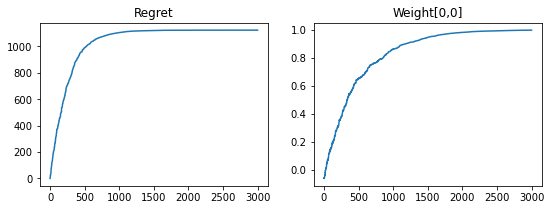

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
axs[0].plot(info.loss.cumsum())
axs[0].set_title("Regret")

axs[1].plot(info.params["linear"]["w"][:, 0, 0])
axs[1].set_title("Weight[0,0]")

We have sub-linear regret!

##  Online learning with Gym

Now we will recast the online linear regression learning task as a reinforcement learning task
implemented with the `GymFeedback` module of WAX-ML.

For that, we define:
- obserbations (`obs`) : pairs  `(x, y)` of features and labels
- raw observations (`raw_obs`): pairs `(x, noise)`  of features and noise.

### Linear regression agent

In WAX-ML, an agent is a simple function with the following API:
<div align="center">
<img src="../tikz/agent.png" alt="logo" width="20%"></img>
</div>

Let's define a simple linear regression agent with the elements we have defined so far.

In [21]:
def linear_regression_agent(obs):
    x, y = obs

    @jit_init_apply
    @hk.transform_with_state
    def model(x):
        return hk.Linear(output_size=1, with_bias=False)(x)

    opt = optax.sgd(1e-3)

    @jax.jit
    def loss(y_pred, y):
        return jnp.mean(jnp.square(y_pred - y))

    return OnlineSupervisedLearner(model, opt, loss)(x, y)

### Linear regression environment

In WAX-ML, an environment is a simple function with the following API:
<div align="center">
<img src="../tikz/env.png" alt="logo" width="20%"></img>
</div>

Let's now define a linear regression environment that, for the moment,
have static weights.

It is responsible for generating the real labels and evaluating the agent's reward.


For the evaluation of the reward, we need the `Lag` module to evaluate the action of
the agent with the labels generated in the previous time step.

In [22]:
from wax.modules import Lag

In [23]:
def stationary_linear_regression_env(action, raw_obs):

    # Only the environment now the true value of the parameters
    w_true = -jnp.ones(3)

    # The environment has its proper loss definition
    @jax.jit
    def loss(y_pred, y):
        return jnp.mean(jnp.square(y_pred - y))

    # raw observation contains features and generative noise
    x, noise = raw_obs

    # generate targets
    y = x @ w_true + noise
    obs = (x, y)

    y_previous = Lag(1)(y)
    # evaluate the prediction made by the agent
    y_pred = action
    reward = loss(y_pred, y_previous)

    return reward, obs, {}

### Generate raw observation

Let's define a function that generate the raw observation:

In [24]:
def generate_many_raw_observations(T=300, sigma=1.0e-2, rng=None):
    rng = jax.random.PRNGKey(42) if rng is None else rng
    X = jax.random.normal(rng, (T, 3))
    noise = sigma * jax.random.normal(rng, (T,))
    return (X, noise)

### Implement Feedback

We are now ready to set things up with the `GymFeedback` module implemented in WAX-ML.

It implements the following feedback loop:
<div align="center">
<img src="../tikz/gymfeedback.png" alt="logo" width="50%"></img>
</div>

Equivalently, it can be described with the pair of `init` and `apply` functions:
<div align="center">
<img src="../tikz/gymfeedback_init_apply.png" alt="logo" width="100%"></img>
</div>

In [25]:
from wax.modules import GymFeedback

In [26]:
@hk.transform_with_state
def gym_fun(raw_obs):
    return GymFeedback(
        linear_regression_agent, stationary_linear_regression_env, return_action=True
    )(raw_obs)

And now we can unroll it on a sequence of raw observations!

In [27]:
seq = hk.PRNGSequence(42)
T = 3000
raw_observations = generate_many_raw_observations(T)
rng = next(seq)
(gym_output, gym_info) = unroll(gym_fun, rng=rng, skip_first=True)(raw_observations)

Let's visualize the outputs.


We now use `pd.Series` to represent the reward sequence since its first value is Nan due to the use of the lag operator.

In [28]:
import pandas as pd

Text(0.5, 1.0, 'Weight[0,0]')

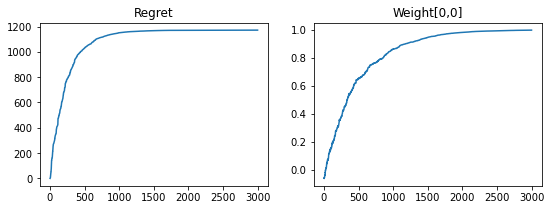

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
pd.Series(gym_output.reward).cumsum().plot(ax=axs[0], title="Regret")
axs[1].plot(info.params["linear"]["w"][:, 0, 0])
axs[1].set_title("Weight[0,0]")

## Non-stationary environment

Now, let's implement a non-stationary environment.

We implement it so that the sign of the weight is reversed after 2000$ steps.

In [30]:
class NonStationaryEnvironment(hk.Module):
    def __call__(self, action, raw_obs):

        step = hk.get_state("step", [], init=lambda *_: 0)

        # Only the environment now the true value of the parameters
        # at step 2000 we flip the sign of the true parameters !
        w_true = hk.cond(
            step < 2000,
            step,
            lambda step: -jnp.ones(3),
            step,
            lambda step: jnp.ones(3),
        )

        # The environment has its proper loss definition
        @jax.jit
        def loss(y_pred, y):
            return jnp.mean(jnp.square(y_pred - y))

        # raw observation contains features and generative noise
        x, noise = raw_obs

        # generate targets
        y = x @ w_true + noise
        obs = (x, y)

        # evaluate the prediction made by the agent
        y_previous = Lag(1)(y)
        y_pred = action
        reward = loss(y_pred, y_previous)

        step += 1
        hk.set_state("step", step)

        return reward, obs, {}

Now let's run a gym simulation to see how the agent adapt to the
change of environment.

In [31]:
@hk.transform_with_state
def gym_fun(raw_obs):
    return GymFeedback(
        linear_regression_agent, NonStationaryEnvironment(), return_action=True
    )(raw_obs)

In [32]:
T = 6000
raw_observations = generate_many_raw_observations(T)
rng = jax.random.PRNGKey(42)
(gym_output, gym_info) = unroll(gym_fun, rng=rng, skip_first=True)(
    raw_observations,
)

In [33]:
import pandas as pd

Text(0.5, 1.0, 'Weight[0,0]')

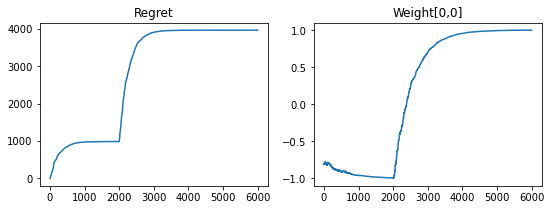

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
pd.Series(gym_output.reward).cumsum().plot(ax=axs[0], title="Regret")
axs[1].plot(gym_info.agent.params["linear"]["w"][:, 0, 0])
axs[1].set_title("Weight[0,0]")
# plt.savefig("../_static/online_linear_regression_regret.png")

It adapts!

The regret first converges, then jumps on step 2000 and finally readjusts to the new regime.

We see that the weights converge to the correct values in both regimes.